In [1]:
import os
import random
import json
import pickle

import tensorflow as tf
import kagglehub as kh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2025-02-22 21:53:16.242444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(42)

In [3]:
path = kh.dataset_download("msafi04/iss-docking-dataset")

In [4]:
df = pd.read_csv(os.path.join(path, 'train.csv'))

In [5]:
df.head()

,ImageID,distance,location
0,0,351,"[215, 158]"
1,1,372,"[228, 269]"
2,2,488,"[255, 386]"
3,3,308,"[306, 426]"
4,4,67,"[248, 338]"


In [6]:
n_imgs = len(df)
n_imgs

10000

In [7]:
df['x'] = list(map(lambda x: tuple(json.loads(x))[0], df['location']))
df['y'] = list(map(lambda x: tuple(json.loads(x))[1], df['location']))
df.head()

,ImageID,distance,location,x,y
0,0,351,"[215, 158]",215,158
1,1,372,"[228, 269]",228,269
2,2,488,"[255, 386]",255,386
3,3,308,"[306, 426]",306,426
4,4,67,"[248, 338]",248,338


In [8]:
df['x'] -= 256
df['y'] -= 256
df['theta_1'] = [np.arctan(df['y'][_]/df['x'][_])+np.pi if df['x'][_] < 0 else np.arctan(df['y'][_]/df['x'][_]) for _ in range(len(df))]
df['theta'] = [df['theta_1'][_]+2*np.pi if df['theta_1'][_] < 0 else df['theta_1'][_] for _ in range(len(df))]
df.head()

/var/folders/kx/d3ql1rx137x9zq1gyqzqdyhm0000gn/T/ipykernel_15016/683084603.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  df['theta_1'] = [np.arctan(df['y'][_]/df['x'][_])+np.pi if df['x'][_] < 0 else np.arctan(df['y'][_]/df['x'][_]) for _ in range(len(df))]


,ImageID,distance,location,x,y,theta_1,theta
0,0,351,"[215, 158]",-41,-98,4.316150,4.316150
1,1,372,"[228, 269]",-28,13,2.706922,2.706922
2,2,488,"[255, 386]",-1,130,1.578488,1.578488
3,3,308,"[306, 426]",50,170,1.284745,1.284745
4,4,67,"[248, 338]",-8,82,1.668050,1.668050


In [9]:
print(np.min(df['theta']))
print(np.max(df['theta']))

0.0
6.268900564592189


In [10]:
df['theta'] /= np.max(df['theta'])
df.head()

,ImageID,distance,location,x,y,theta_1,theta
0,0,351,"[215, 158]",-41,-98,4.316150,0.688502
1,1,372,"[228, 269]",-28,13,2.706922,0.431802
2,2,488,"[255, 386]",-1,130,1.578488,0.251797
3,3,308,"[306, 426]",50,170,1.284745,0.204939
4,4,67,"[248, 338]",-8,82,1.668050,0.266083


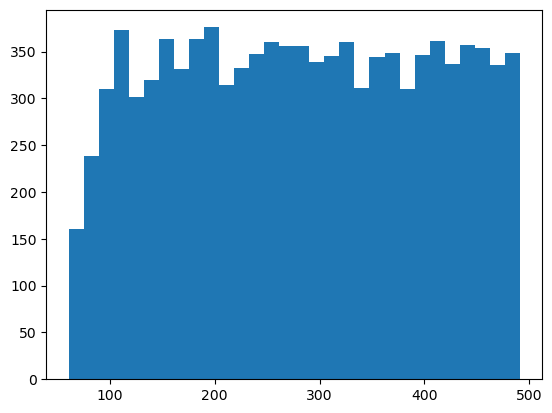

In [11]:
plt.hist(df['distance'], bins=30)
plt.show()

In [12]:
image_paths = []
for f in os.listdir(os.path.join(path, 'train')):
    if f.startswith('.') or '.jpg' not in f:
        continue
    image_paths.append(os.path.join(path, 'train', f))
len(image_paths)

10000

In [13]:
distances = df.get('distance').tolist()
thetas = df.get('theta').tolist()

distances[:5]
thetas[:5]

[0.6885018499340234,
 0.43180178255334023,
 0.25179670127264664,
 0.20493942627420744,
 0.26608326417998845]

In [14]:
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

In [15]:
combined_distances = list(zip(image_paths, distances))
combined_thetas = list(zip(image_paths, thetas))
random.Random(42).shuffle(combined_distances)
random.Random(42).shuffle(combined_thetas)

In [16]:
image_paths_distances, distances = zip(*combined_distances)
image_paths_thetas, thetas = zip(*combined_thetas)

In [17]:
train_split = int(0.7*n_imgs)
val_split = train_split + int(0.1*n_imgs)
test_split = val_split + int(0.2*n_imgs)
print(train_split, val_split, test_split)

7000 8000 10000


In [18]:
train_image_paths_distances = np.array(image_paths_distances[:train_split]).flatten()
train_distances = np.array(distances[:train_split]).flatten()
train_image_paths_thetas = np.array(image_paths_thetas[:train_split]).flatten()
train_thetas = np.array(thetas[:train_split])

val_image_paths_distances = np.array(image_paths_distances[train_split:val_split]).flatten()
val_distances = np.array(distances[train_split:val_split]).flatten()
val_image_paths_thetas = np.array(image_paths_thetas[train_split:val_split]).flatten()
val_thetas = np.array(thetas[train_split:val_split])

test_image_paths_distances = np.array(image_paths_distances[val_split:test_split]).flatten()
test_distances = np.array(distances[val_split:test_split]).flatten()
test_image_paths_thetas = np.array(image_paths_thetas[val_split:test_split]).flatten()
test_thetas = np.array(thetas[val_split:test_split])

In [19]:
train_distances = (train_distances-np.min(train_distances))/(np.max(train_distances)-np.min(train_distances))
val_distances = (val_distances-np.min(val_distances))/(np.max(val_distances)-np.min(val_distances))
test_distances = (test_distances-np.min(test_distances))/(np.max(test_distances)-np.min(test_distances))

In [20]:
print(np.max(train_thetas))
print(np.min(train_thetas))

0.9997060264017189
0.0


In [21]:
print(np.max(train_distances))
print(np.min(train_distances))

1.0
0.0


In [ ]:
def as_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

: 

In [ ]:
train_image_paths_distances = [as_image(_) for _ in train_image_paths_distances]
val_image_paths_distances = [as_image(_) for _ in val_image_paths_distances]
test_image_paths_distances = [as_image(_) for _ in test_image_paths_distances]

train_image_paths_distances = np.array(train_image_paths_distances)
val_image_paths_distances = np.array(val_image_paths_distances)
test_image_paths_distances = np.array(test_image_paths_distances)

In [ ]:
print(train_image_paths_distances.shape)

(7000, 512, 512, 3)


In [ ]:
img_height = img_width = 512
net = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
net.trainable = False

/usr/local/Caskroom/miniconda/base/envs/hai/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:
# If this is commented out, it is to reduce file length as this output is long
# net.summary()

In [ ]:
lr = 1e-4
epochs = 50

flatten = net.output
flatten = tf.keras.layers.Flatten()(flatten)

regression = tf.keras.layers.Dense(32, activation='relu')(flatten)
regression = tf.keras.layers.Dense(16, activation='relu')(regression)

# DISTANCE REGRESSION
left_head = tf.keras.layers.Dense(8, activation='relu')(regression)
left_head = tf.keras.layers.Dense(1, activation='relu', name='distance')(left_head)

# THETA REGRESSION
right_head = tf.keras.layers.Dense(1, activation='relu', name='theta')(regression)

model = tf.keras.Model(inputs=net.input, outputs=(left_head, right_head))

losses = { 'distance': 'mean_absolute_error', 'theta': 'mean_absolute_error' }
loss_weights = { 'distance': 1.0, 'theta': 4.0 }

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss=losses, optimizer=opt, loss_weights=loss_weights)

# If this is commented out, it is to reduce file length as this output is long
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 256, 256,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 256, 256,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 257, 257,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 128, 128,  │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        256 │ expanded_conv_sq

 Total params: 5,658,434 (21.59 MB)

 Trainable params: 4,719,314 (18.00 MB)

 Non-trainable params: 939,120 (3.58 MB)

None


In [ ]:
train_targets = { 'distance': train_distances, 'theta': train_thetas }
test_targets = { 'distance': test_distances, 'theta': test_thetas }
val_targets = { 'distance': val_distances, 'theta': val_thetas }

print(train_targets)

batch_size = 32

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_3.keras', monitor='val_loss', save_best_only=True)]
history = model.fit(train_image_paths_distances, train_targets,
                    validation_data = (val_image_paths_distances, val_targets),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks)

{'distance': array([0.35813953, 0.13023256, 0.50930233, ..., 0.68837209, 0.93953488,
       0.14418605]), 'theta': array([0.75929934, 0.7539091 , 0.77064459, ..., 0.1179277 , 0.72879308,
       0.20489145])}
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - distance_loss: 0.3207 - loss: 0.7939 - theta_loss: 0.4732 - val_distance_loss: 0.1451 - val_loss: 0.6207 - val_theta_loss: 0.4720
Epoch 2/50
136/219 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - distance_loss: 0.1379 - loss: 0.6109 - theta_loss: 0.4730

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss3.png')
plt.show()

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['distance_loss'])
plt.plot(history.history['val_distance_loss'])
plt.title('Model Distance MAE')
plt.ylabel('Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('distancemae3.png')
plt.show()

In [ ]:
plt.plot(history.history['x_loss'])
plt.plot(history.history['val_x_loss'])
plt.title('Model X MAE')
plt.ylabel('X Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('xmae3.png')
plt.show()

In [ ]:
plt.plot(history.history['y_loss'])
plt.plot(history.history['val_y_loss'])
plt.title('Model Y MAE')
plt.ylabel('Y Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('ymae3.png')
plt.show()

In [ ]:
model.evaluate(test_image_paths_distances, test_targets)

In [ ]:
predictions = model.predict(test_image_paths_distances)

In [ ]:
locations = predictions[1:3]
x, y = np.array(locations[0]).flatten(), np.array(locations[1]).flatten()
print(np.array(x).shape)
print(np.array(y).shape)
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

print(train_locations[:5])

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()